## Train full cell-dyn on various models

In [2]:
import os
os.chdir("T:/laupodteam/AIOS/Chontira/CellDynClustering")
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import hdbscan
from evaluation.fast_dunn_index import dunn_fast
from evaluation.util import *
import ast
from graphic_stuffs import *
import time


## Evaluators

evaluators= {'silhouette_score': silhouette_score,
            'davies_bouldin_score': davies_bouldin_score,
            'dunn_fast': dunn_fast}

dnd= {'davies_bouldin_score': davies_bouldin_score,
    'dunn_fast': dunn_fast}

db= {'davies_bouldin_score': davies_bouldin_score}



## Load data

In [5]:
dm6_with_labels = pd.read_feather("data/embedded_celldyn_ALL_nn50_ndim6_w_labels_.feather")
others_labels = dm6_with_labels.loc[:,dm6_with_labels.columns.isin(['sex', 'age','study_id', 'analysis_dt', 'sample_dt'])]
dm6 = dm6_with_labels.iloc[:, 0:6]
dm6.shape

(3093792, 6)

In [6]:
dm6_sampled = dm6.sample(20000)

## HDBSCAN

In [4]:
chosen_param = {"min_cluster_size":2,
                "metric": 'manhattan'}
model, labels = fit_predict_score( dm6_sampled, hdbscan.HDBSCAN, param=chosen_param, evaluators=None)

#plot_multi_scatter_with_labels(data=dm6_sampled, labels=labels, row=12,col=3)
plot_scatter_preset_with_labels(dm6_sampled,labels,[0,1])
#model.condensed_tree_.plot(select_clusters=True,
                               #selection_palette=sns.color_palette('deep', 8))

NameError: name 'dm6_sampled' is not defined

In [33]:
dm6[dm6["dim_2"] > 8]

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6
8992,0.570197,9.696685,-0.257320,7.520121,9.329283,4.807788
56673,0.570100,9.696831,-0.257385,7.520209,9.329390,4.807680
74621,0.570298,9.696581,-0.257323,7.520169,9.329244,4.807820
198638,0.570597,9.696402,-0.257374,7.520327,9.329067,4.808060
200305,0.570240,9.696658,-0.257168,7.520135,9.329167,4.807825
...,...,...,...,...,...,...
3074046,0.569986,9.696917,-0.257373,7.520075,9.329407,4.807732
3076666,0.570136,9.696749,-0.257286,7.520181,9.329264,4.807850
3093727,0.570167,9.696804,-0.257397,7.520089,9.329281,4.807743
3093728,0.570475,9.696487,-0.257296,7.520210,9.329148,4.807948


In [7]:
chosen_param = {"min_cluster_size":100,
                "metric": 'euclidean'}
model, labels = fit_predict_score( dm6, hdbscan.HDBSCAN, param=chosen_param, evaluators=None)

Unique predicted labels [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23] with their amounts [   3019     923    5642     728     140    1149 3057635     148     444
     812     351     877     317     429     144    2933     387     576
     402    7469     286     287     243    8210     241]
Time taken 60.62 minutes


In [8]:
subsampling_evaluate_scores(dm6,hdbscan.HDBSCAN, param=chosen_param,evaluators=dnd, subsampling=20000, num_iters=2)

Metric                                         Score
---------------------------------------  -----------
davies_bouldin_score                     1.18317
davies_bouldin_score standard deviation  0.310078
dunn_fast                                4.53914e-05
dunn_fast standard deviation             5.30399e-06


Unique predicted labels 26
Time taken 0.96 minutes


In [19]:
## Dynamic cut the trees with HDBSCAN
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
chosen_param = {"min_cluster_size":2,
                "metric": 'cityblock'}
distance = pdist(dm6_sampled, metric="cityblock")
hd=hdbscan.HDBSCAN(**chosen_param).fit(dm6_sampled)

linkage = hd.single_linkage_tree_.to_numpy()
clusters = cutreeHybrid(linkage,distance, minClusterSize=2)

..cutHeight not given, setting it to 21.96753134518862  ===>  99% of the (truncated) height range in dendro.
..done.


[ 0  1  2  3  4  5  6  7  8  9 10 11]


c:\Users\cchumsae\Anaconda3\envs\CellDynCluster\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


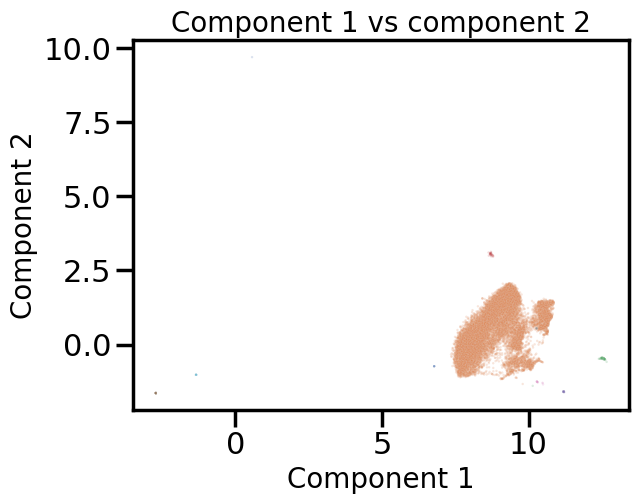

In [20]:
print(np.unique(clusters["labels"]))
plot_scatter_preset_with_labels(dm6_sampled,clusters["labels"],[0,1])

## Gaussian mixture model

Metric                     Score
--------------------  ----------
silhouette_score      0.299838
davies_bouldin_score  1.09922
dunn_fast             0.00116641


Unique predicted labels [ 0  1  2  3  4  5  6  7  8  9 10] with their amounts [1932   36   19 3563 1068 1115 1240 4095 6833   76   23]
Time taken 0.67 minutes


c:\Users\cchumsae\Anaconda3\envs\CellDynCluster\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


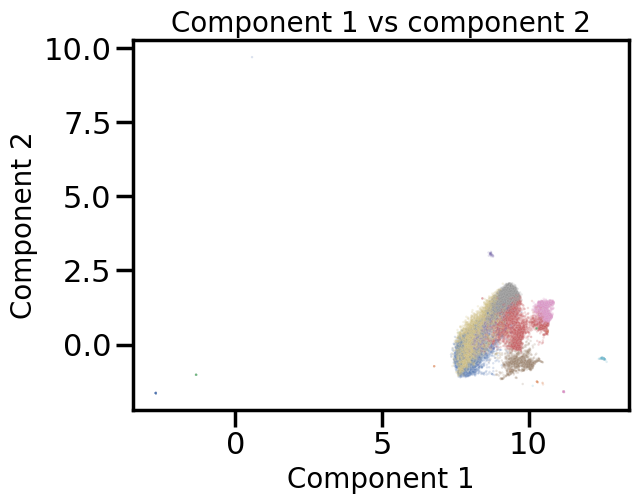

In [21]:
from sklearn.mixture import GaussianMixture

chosen_param = {"n_components" : 11}

model, labels = fit_predict_score( dm6_sampled, GaussianMixture, param=chosen_param, evaluators=evaluators)

#plot_multi_scatter_with_labels(data=dm6_sampled, labels=labels, row=12,col=3)
plot_scatter_preset_with_labels(dm6_sampled,labels,[0,1])

ValueError: Min samples and min cluster size must be integers!

## Average linkage with dynamic tree cut

In [22]:
from scipy.cluster.hierarchy import linkage
distances = pdist(dm6_sampled, "euclidean")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances,minClusterSize=2)

..cutHeight not given, setting it to 13.833923738367746  ===>  99% of the (truncated) height range in dendro.
..done.


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


c:\Users\cchumsae\Anaconda3\envs\CellDynCluster\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


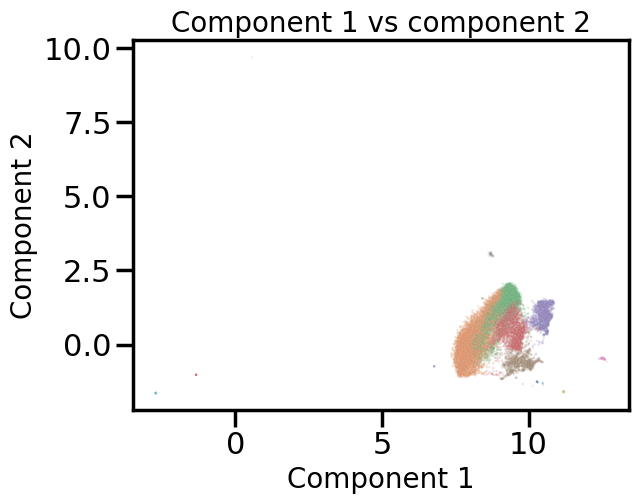

In [24]:
print(np.unique(clusters['labels']))
plot_scatter_preset_with_labels(dm6_sampled,clusters['labels'],[0,1])